#Comparing SSWIDL's aia_prep.pro to SunPy's aiaprep()

##Aim

This document aims to provide a qualitative comparison between SSWIDL's aiaprep.pro, and SunPy's `aiaprep()`. The purpose is not to show which one is 'more right' - I leave that task for someone far better at maths than me - but simply to demonstrate where the results of the two implementations differ.

##Data

For this demonstration I will use an AIA image from 2014-01-11 as the original. The IDL-processed level 1.5 version of this image has been saved to a fits file already using IDL 8.2.3 and aiaprep.pro version 4.11. The SunPy-processed version is calculated here, with Python 2.7.8 and SunPy 0.5.4.

AIA images can be fairly noisy around the edges of the image, which will cause some pixels in those areas to have very different values after the transformation. The values of all pixels further from the solar centre than 1.3 solar radii are therefore set to be constant to reduce the effect of this noise.

In [1]:
# Import statements. Nothing to see here.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sunpy
from sunpy.map import Map
from sunpy.instr.aia import aiaprep

c:\users\drew\anaconda\lib\site-packages\glymur-0.8.0-py2.7.egg\glymur\lib\config.py:151: UserWarning: Neither the openjp2 nor the openjpeg library could be loaded.  
  warnings.warn(msg)


In [2]:
# Load original image
origim = Map("aia171_2014-01-11T00_00.fits")
# Trim the image to <= 1.3 solar radii.
# Apologies for the clunky implementation, I couldn't figure out how to do this using wcs.
lowx, highx = (origim.xrange[0] / origim.scale['x'],
               origim.xrange[1] / origim.scale['x'])
lowy, highy = (origim.yrange[0] / origim.scale['y'],
               origim.yrange[1] / origim.scale['y'])
x_grid, y_grid = np.mgrid[lowx:highx-1, lowy:highy-1]
r_grid = np.sqrt((x_grid ** 2.0) + (y_grid ** 2.0))
outer_rad = (origim.rsun_arcseconds * 1.3) / origim.scale['x']
origim.data[r_grid > outer_rad] = 1

# Process original image with SunPy, and trim again
pypreppedim = aiaprep(origim)
lowx, highx = (pypreppedim.xrange[0] / pypreppedim.scale['x'],
               pypreppedim.xrange[1] / pypreppedim.scale['x'])
lowy, highy = (pypreppedim.yrange[0] / pypreppedim.scale['y'],
               pypreppedim.yrange[1] / pypreppedim.scale['y'])
x_grid, y_grid = np.mgrid[lowx:highx-1, lowy:highy-1]
r_grid = np.sqrt((x_grid ** 2.0) + (y_grid ** 2.0))
outer_rad = (pypreppedim.rsun_arcseconds * 1.3) / pypreppedim.scale['x']
pypreppedim.data[r_grid > outer_rad] = 1

# Load image processed with IDL, and trim
idlpreppedim = Map("aia171_2014-01-11T00_00_idlprepped.fits")
lowx, highx = (idlpreppedim.xrange[0] / idlpreppedim.scale['x'],
               idlpreppedim.xrange[1] / idlpreppedim.scale['x'])
lowy, highy = (idlpreppedim.yrange[0] / idlpreppedim.scale['y'],
               idlpreppedim.yrange[1] / idlpreppedim.scale['y'])
x_grid, y_grid = np.mgrid[lowx:highx-1, lowy:highy-1]
r_grid = np.sqrt((x_grid ** 2.0) + (y_grid ** 2.0))
outer_rad = (idlpreppedim.rsun_arcseconds * 1.3) / idlpreppedim.scale['x']
idlpreppedim.data[r_grid > outer_rad] = 1

c:\Users\Drew\Anaconda\lib\site-packages\sunpy-0.5.4-py2.7.egg\sunpy\image\transform.py:121: RuntimeWarning: Input integer data has been cast to float64
  warnings.warn("Input integer data has been cast to float64", RuntimeWarning)


We can easily compare some of the relevant header information to check that it has been updated correctly by both versions:

In [3]:
print 'Processing level'
print '  Original:', origim.processing_level
print '  SunPy:', pypreppedim.processing_level
print '  IDL:', idlpreppedim.processing_level, '\n'

print 'Pixel scale'
print '  Original:', origim.scale
print '  SunPy:', pypreppedim.scale
print '  IDL:', idlpreppedim.scale, '\n'

print 'Solar centre coordinates'
print '  Original:', origim.center
print '  SunPy:', pypreppedim.center
print '  IDL:', idlpreppedim.center, '\n'

print 'Solar centre pixel position'
print '  Original:', origim.reference_pixel
print '  SunPy:', pypreppedim.reference_pixel
print '  IDL:', idlpreppedim.reference_pixel, '\n'

print 'Rotation matrix'
print '  Original:\n', origim.rotation_matrix
print '  SunPy:\n', pypreppedim.rotation_matrix
print '  IDL:\n', idlpreppedim.rotation_matrix, '\n'

Processing level
  Original: 1.0
  SunPy: 1.5
  IDL: 1.5 

Pixel scale
  Original: {'y': 0.599489, 'x': 0.599489}
  SunPy: {'y': 0.6, 'x': 0.6}
  IDL: {'y': 0.600000023842, 'x': 0.600000023842} 

Solar centre coordinates
  Original: {'y': 1.4747195599288716, 'x': -4.496167500000183}
  SunPy: {'y': 0.0, 'x': 0.0}
  IDL: {'y': 0.0, 'x': 0.0} 

Solar centre pixel position
  Original: {'y': 2046.040039, 'x': 2056.0}
  SunPy: {'y': 2048.5, 'x': 2048.5}
  IDL: {'y': 2048.5, 'x': 2048.5} 

Rotation matrix
  Original:
[[  9.99999943e-01  -3.38506602e-04]
 [  3.38506602e-04   9.99999943e-01]]
  SunPy:
[[  1.00000000e+00   5.42101086e-20]
 [ -5.42101086e-20   1.00000000e+00]]
  IDL:
[[ 1. -0.]
 [ 0.  1.]] 



Notice in the above output that the IDL aia_prep doesn't quite set the image scale to exactly 0.6 arcsec per pixel, although it's probably close enough. Similarly, SunPy's `aiaprep()` sets the diagonals of the rotation matrix not to exactly zero, but very close.

##Comparing SunPy to the original
Let's compare the SunPy-processed image to the original. We should expect the images to be very similar, since the pointing and rotation of AIA are usually only off by a little.

c:\Users\Drew\Anaconda\lib\site-packages\sunpy-0.5.4-py2.7.egg\sunpy\map\mapbase.py:1056: Warning: This map is not aligned. Plot axes may be incorrect
  Warning)


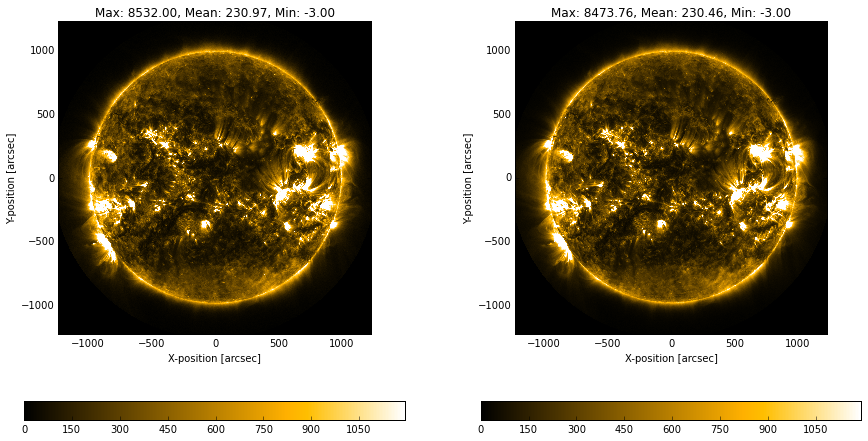

In [4]:
"""Visually compare original image to image processed using SunPy"""

fig = plt.figure(figsize=(15, 8))

fig.add_subplot(1, 2, 1)
origim.plot()
plt.title('Max: {:.2f}, Mean: {:.2f}, Min: {:.2f}'.format(origim.max(), origim.mean(), origim.min()))
plt.colorbar(orientation='horizontal')

fig.add_subplot(1, 2, 2)
pypreppedim.plot()
plt.title('Max: {:.2f}, Mean: {:.2f}, Min: {:.2f}'.format(pypreppedim.max(), pypreppedim.mean(), pypreppedim.min()))
plt.colorbar(orientation='horizontal')
plt.show()

The images are indeed very nearly the same, so nothing has gone wildly wrong.

Now let's look at the actual difference between the two images:

In [5]:
"""Assess difference of SunPy image from original."""

diffim1 = Map(pypreppedim.data.copy(), pypreppedim.meta.copy())
# Calculate percentage difference 
diffim1.data = ((origim.data - pypreppedim.data) / origim.data) * 100

# Check some numbers
meandiff = diffim1.data[np.isfinite(diffim1.data)].mean()
stddiff = diffim1.data[np.isfinite(diffim1.data)].std()
maxdiff = diffim1.data[np.isfinite(diffim1.data)].max()
mindiff = diffim1.data[np.isfinite(diffim1.data)].min()
print 'Min: {:.3f}'.format(mindiff)
print 'Max: {:.3f}'.format(maxdiff)
print 'Mean: {:.3f}'.format(meandiff)
print 'Std Dev: {:.3f}'.format(stddiff)
print 'Discounted: {}'.format(diffim1.size - np.count_nonzero(np.isfinite(diffim1.data)))

Min: -7162.148
Max: 1614.943
Mean: -2.198
Std Dev: 36.987
Discounted: 950


c:\Users\Drew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: RuntimeWarning: divide by zero encountered in divide


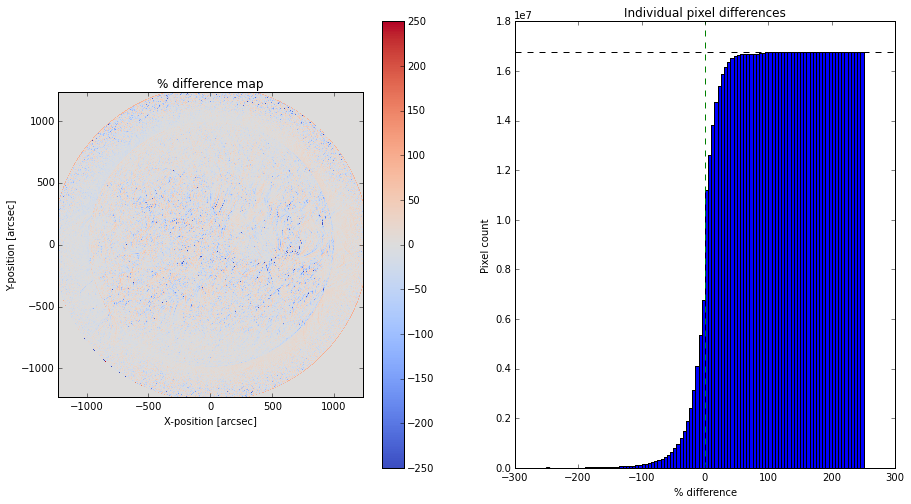

In [6]:
"""Display difference"""

# Plot difference Map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
plt.sca(ax[0])
diffim1.plot(cmap='coolwarm', vmin=-250, vmax=250)
plt.title('% difference map')
plt.colorbar()

# Plot histogram of differences
plt.sca(ax[1])
plt.hist(diffim1.data.flatten(), range=(-250, 250), bins=100, cumulative=True)
plt.axhline(diffim1.size, linestyle='--', color='black')
plt.axvline(0, linestyle='--', color='green')
plt.title('Individual pixel differences')
plt.xlabel('% difference')
plt.ylabel('Pixel count')
plt.show()

The difference image on the left shows that the processed image is very similar to the original, and differs most in areas where there are small-scale features or noise.

The cumulative histogram on the right shows that most pixels vary very little from their original values after applying `aiaprep()`. The horizontal dashed line indicates the total number of pixels in the image, and the vertical line denotes zero difference from the original.

Note that some pixels have been discounted, since a zero in the original image will result in an infinite difference value.

##Comparing IDL to the original

Now let's do the same again for IDL.

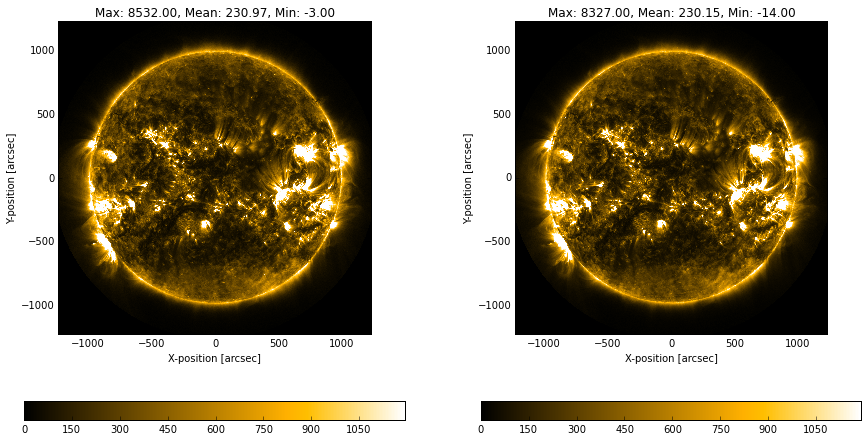

In [7]:
"""Visually compare original image to image processed using IDL"""

fig = plt.figure(figsize=(15, 8))

fig.add_subplot(1, 2, 1)
origim.plot()
plt.title('Max: {:.2f}, Mean: {:.2f}, Min: {:.2f}'.format(origim.max(), origim.mean(), origim.min()))
plt.colorbar(orientation='horizontal')

fig.add_subplot(1, 2, 2)
idlpreppedim.plot()
plt.title('Max: {:.2f}, Mean: {:.2f}, Min: {:.2f}'.format(idlpreppedim.max(), idlpreppedim.mean(), idlpreppedim.min()))
plt.colorbar(orientation='horizontal')
plt.show()

Again, the processed image is very similar to the original image.

In [8]:
"""Assess difference of IDL image from original."""

diffim2 = Map(idlpreppedim.data.copy(), idlpreppedim.meta.copy())
# Calculate percentage difference 
diffim2.data = ((origim.data - idlpreppedim.data) / origim.data) * 100

# Check some numbers
meandiff = diffim2.data[np.isfinite(diffim2.data)].mean()
stddiff = diffim2.data[np.isfinite(diffim2.data)].std()
maxdiff = diffim2.data[np.isfinite(diffim2.data)].max()
mindiff = diffim2.data[np.isfinite(diffim2.data)].min()
print 'Min: {:.3f}'.format(mindiff)
print 'Max: {:.3f}'.format(maxdiff)
print 'Mean: {:.3f}'.format(meandiff)
print 'Std Dev: {:.3f}'.format(stddiff)
print 'Discounted: {}'.format(diffim2.size - np.count_nonzero(np.isfinite(diffim2.data)))

Min: -6900.000
Max: 1600.000
Mean: -3.438
Std Dev: 72.191
Discounted: 950


c:\Users\Drew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: RuntimeWarning: divide by zero encountered in divide
c:\Users\Drew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: RuntimeWarning: invalid value encountered in divide


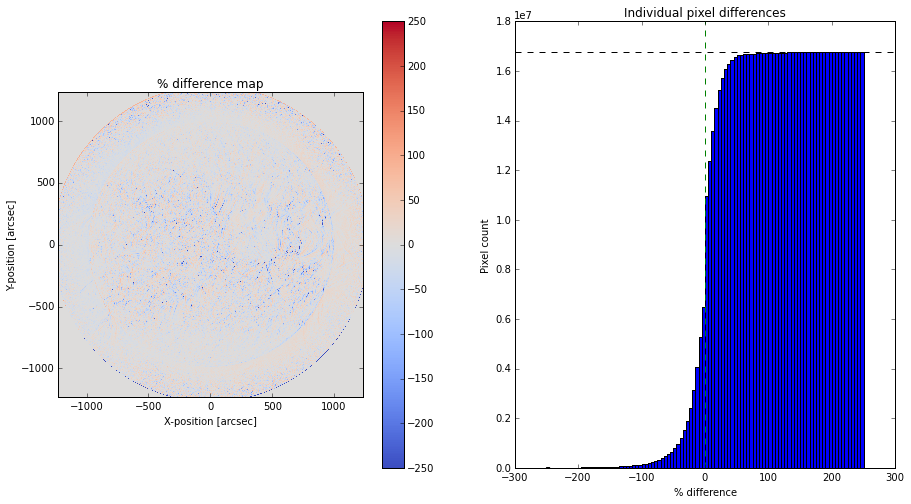

In [9]:
"""Display difference"""

# Plot difference Map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
plt.sca(ax[0])
diffim2.plot(cmap='coolwarm', vmin=-250, vmax=250)
plt.title('% difference map')
plt.colorbar()

# Plot histogram of differences
plt.sca(ax[1])
plt.hist(diffim2.data.flatten(), range=(-250, 250), bins=100, cumulative=True)
plt.axhline(diffim2.size, linestyle='--', color='black')
plt.axvline(0, linestyle='--', color='green')
plt.title('Individual pixel differences')
plt.xlabel('% difference')
plt.ylabel('Pixel count')
plt.show()

And again, most pixels show a very small change in value, with the greatest change where there are small-scale variations in the original image.

##Comparing SunPy to IDL

Finally, perhaps the most important comparison is between the resultant images from both versions of the method.

In [10]:
"""Assess difference of IDL image from original."""

diffim3 = Map(idlpreppedim.data.copy(), idlpreppedim.meta.copy())
# Calculate percentage difference 
diffim3.data = ((idlpreppedim.data - pypreppedim.data) / idlpreppedim.data) * 100

# Check some numbers
meandiff = diffim3.data[np.isfinite(diffim3.data)].mean()
stddiff = diffim3.data[np.isfinite(diffim3.data)].std()
maxdiff = diffim3.data[np.isfinite(diffim3.data)].max()
mindiff = diffim3.data[np.isfinite(diffim3.data)].min()
print 'Min: {:.3f}'.format(mindiff)
print 'Max: {:.3f}'.format(maxdiff)
print 'Mean: {:.3f}'.format(meandiff)
print 'Std Dev: {:.3f}'.format(stddiff)
print 'Discounted: {}'.format(diffim3.size - np.count_nonzero(np.isfinite(diffim3.data)))

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.
Min: -5431.217
Max: 526.582
Mean: -0.785
Std Dev: 10.855
Discounted: 919


c:\Users\Drew\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: RuntimeWarning: divide by zero encountered in divide


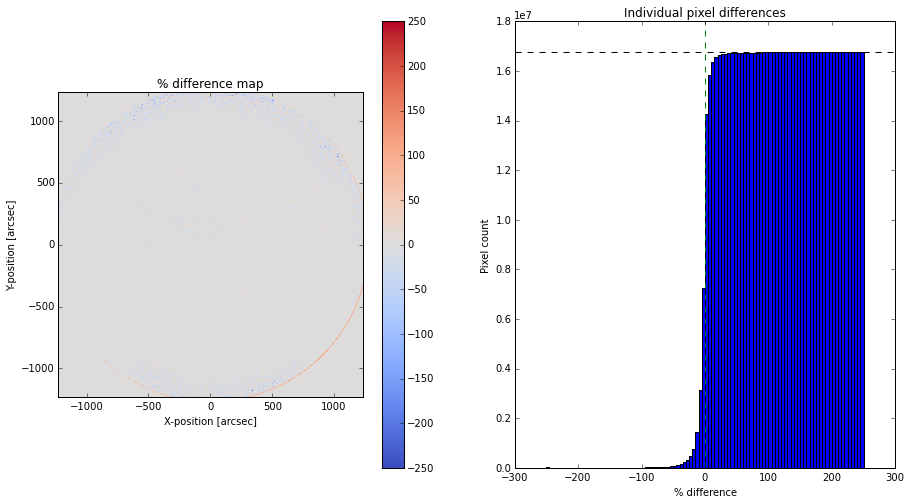

In [11]:
"""Display difference"""

# Plot difference Map
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
plt.sca(ax[0])
diffim3.plot(cmap='coolwarm', vmin=-250, vmax=250)
plt.title('% difference map')
plt.colorbar()

# Plot histogram of differences
plt.sca(ax[1])
plt.hist(diffim3.data.flatten(), range=(-250, 250), bins=100, cumulative=True)
plt.axhline(diffim3.size, linestyle='--', color='black')
plt.axvline(0, linestyle='--', color='green')
plt.title('Individual pixel differences')
plt.xlabel('% difference')
plt.ylabel('Pixel count')
plt.show()

We see here that the processed images are more similar to each other than either is to the original. Some noisy areas still remain around the edges of the difference image. The solar disk, on the other hand, shows only very small differences between the output of the two methods. This suggests that IDL's aia_prep.pro and SunPy's `aiaprep()` can be used interchangeably without fear of any great difference in the results.